### Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### 1. Загрузка данных.

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2 , f_classif
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, auc , roc_curve
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [6]:
# Путь к файлам проекта
PATH = r"C:\Users\ivan\YandexDisk\DS\Project_Final\Final_project"
#PATH ='/datasets/final_provider/' 

# Записываем датасеты в переменные
df_contract = pd.read_csv(os.path.join(PATH,'contract.csv'))
df_internet = pd.read_csv(os.path.join(PATH,'internet.csv'))
df_personal = pd.read_csv(os.path.join(PATH,'personal.csv'))
df_phone = pd.read_csv(os.path.join(PATH,'phone.csv'))

**Анализ пропусков**

##### Данные по договорам

In [7]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


##### Данные по использованию интернета

In [9]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


##### Данные по абонентам

In [11]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


##### Данные по использованию телефона

In [13]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [14]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


____
**Анализ дубликатов**

##### Данные по договорам

In [15]:
#  Проверка наличия дубликатов
df_contract.duplicated().sum()

0

##### Данные по использованию интернета

In [16]:
#  Проверка наличия дубликатов
df_internet.duplicated().sum()

0

##### Данные по абонентам

In [17]:
#  Проверка наличия дубликатов
df_personal.duplicated().sum()

0

##### Данные по использованию телефона

In [18]:
#  Проверка наличия дубликатов
df_phone.duplicated().sum()

0

### Выводы:
1. **Contract**. Пропусков и дубликатов нет. Необходимо заменить тип данных в столбцах *BeginDate, EndDate* на **DateTime** и столбца *TotalCharges* на **float**.
2. **Internet**. Пропусков и дубликатов нет. Тип данных соответствует содержанию. Для использования в модели бинарные значения будут преобразованы в 0 и 1.
3. **Personal**. Пропусков и дубликатов нет. Тип данных соответствует содержанию. Непонятен смысл столбцов *SeniorCitizen, Partner, Dependents*.
4. **Phone**. Пропусков и дубликатов нет. Тип данных соответствует содержанию.
 


## 2.  Подготовка данных к анализу


___
**Замена типа данных**

Даты заменяем на тип данных  Datetime.
Для неушедших клиентов указываем дату выгрузки данных.

In [19]:
# Преобразование типа данных
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

#Замена Enddate для неушедших клиентов

df_contract.loc[df_contract['EndDate'] == 'No','EndDate'] = '2020-02-01'
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'] , errors = 'coerce')

In [20]:
# Проверим пропуски при замене типа данных
df_contract[df_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


In [21]:
# Проверим какие значения у других новых клиентов
df_contract[df_contract['BeginDate']=='2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


После замены значения "No" на дату и замены типа данных образуются пропуски в столбце TotalCharges, который заменяем на соответствующее значения  MonthlyCharges.

In [22]:
# Заполнение пропусков после преобразования чисел

# Список индексов строк с пропусками
new_client_charge_ind = df_contract[df_contract['TotalCharges'].isna()]['MonthlyCharges'].index

# Заполнение пропусков
for index in new_client_charge_ind:
    df_contract.loc[index,'TotalCharges'] = df_contract.loc[index,'MonthlyCharges'] 

Проверяем типы данных:

In [23]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


___
**Ушедшие клиенты**

Проверяем количество ушедших клиентов:

In [24]:
df_gone = df_contract[df_contract['EndDate'] != '2020-02-01']
df_gone.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


In [25]:
print('Всего ушедших клиентов:', len(df_gone))

Всего ушедших клиентов: 1869


#### Выводы по подготовке данных:
1. Изменен тип данных дат. В столбце EndDate для неушедших клиентов значение заменено на дату актуализации датасета для дальнейшего учета длительности контракта.
2. Изменен тип данных стоимости на float.
3. Определено количество ушедших клиентов.

    

## План работы:
1. Определить целевой признак.
    - Клиент ушел - 1 (1869 клиентов)
    - Клиент не уходит - 0 (5174 клиентов);
2. Подготовить данные для анализа влияния признаков на целевой признак. Провести исследовательский анализ (EDA). 
3. Определить признаки, которые будут использоваться для обучения модели. 
4. Определить состав обучающей и тестовой выборок. 
5. Определить метрики. 
6. Обучить модели и выбрать одну модель.
7. Предсказать уход клиента, определить метрики на тестовых данных.
8. Сделать выводы и подготовить отчет.

## Вопросы:
1. Что означают признаки *SeniorCitizen	Partner	Dependents*?
2. Есть ли дополнительные данные о клиентах? Возраст? Образование? Работа и т.д.?


## 3. Исследовательский анализ данных

___
**Выделение целевого признака**

Ушедших клиентов маркируем 1, неушедших - 0:

In [26]:
# Добавляем целевой признак
df_contract.loc[df_contract['EndDate']=='2020-02-01', 'Churn'] = 0
df_contract.loc[df_contract['EndDate']!='2020-02-01', 'Churn'] = 1
df_contract['Churn'] = df_contract['Churn'].astype('int')

In [27]:
df_contract.groupby('Churn').count()['customerID']

Churn
0    5174
1    1869
Name: customerID, dtype: int64

**Анализ количественных данных: абонентской, суммарной платы клиента и времени жизни клиента**

In [28]:
# Для удобства выделим переменные с клиентами
gone_client = df_contract[df_contract['Churn']==1]
still_client = df_contract[df_contract['Churn']==0]

Функиця для рисования гистограмм распределения платы.

In [29]:
def hist(df_gone, df_still, column):
    ax = plt.figure(figsize = (12,7))
    sns.distplot(df_gone[column] , bins= 50 , kde=False , color = 'red');
    sns.distplot(df_still[column] , bins= 50 , kde=False );
    ax.legend(labels=['gone_client','still_client']) 
    plt.title(column);

*MonthlyCharges*

In [30]:
print('Статистика ежемесячной платы ушедших клиентов')
gone_client['MonthlyCharges'].describe()

Статистика ежемесячной платы ушедших клиентов


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [31]:
print('Статистика ежемесячной платы действующих клиентов')
still_client['MonthlyCharges'].describe()

Статистика ежемесячной платы действующих клиентов


count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

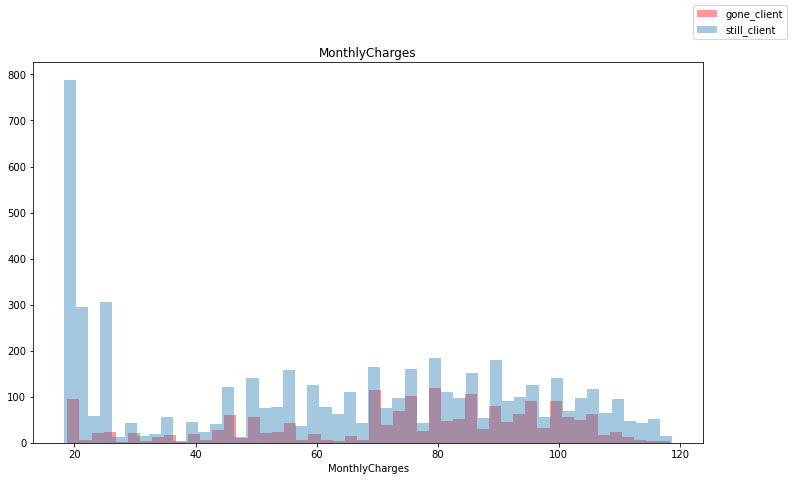

In [32]:
# Распределение абонентской платы
hist(gone_client, still_client, 'MonthlyCharges')

**Анализ категориальных признаков**

В анализе категорианльных признаков рассмотрим основные:
- периодичность оплаты;
- тип оплаты;
- пол;
- пожилой/ не пожилой человек



Для анализа объединяем все признаки в один датафрейм. Предполагаем, что отсутствие по клиенту информации об услугам интернета и телефона означает, что такими услугами он не пользуется, значит пропуски заполняем значение 'No'

In [36]:
def merging(df_1, df_2, df_3, df_4):
    df_full= df_1.merge(df_2, how = 'left', on = 'customerID')
    df_full = df_full.merge(df_3, how = 'left', on = 'customerID')
    df_full = df_full.merge(df_4, how = 'left', on = 'customerID')
    df_full = df_full.fillna('No')
    return df_full

In [37]:
def pie_plot(data , column , title):
    df_plt_pie_0 = data.loc[df_contract['Churn']==0 , column]
    df_plt_pie_1 = data.loc[df_contract['Churn']==1 , column]

    colors = ['grey','blue','red','yellow','green','brown']
    
    sizes_0 = df_plt_pie_0.value_counts().values
    sizes_1 = df_plt_pie_1.value_counts().values
    labels_0 = df_plt_pie_0.value_counts().index
    labels_1 = df_plt_pie_1.value_counts().index
    explode = [0] *len(sizes_0)
    title_0 = title + ' действующих клиентов'
    title_1 = title + ' ушедших клиентов'

    f, (ax1, ax2)= plt.subplots(ncols=2 , sharey = True , figsize = (15,7))
    
    ax1.pie(sizes_0, explode=explode, labels=labels_0, colors=colors, autopct='%1.1f%%')
    ax1.set_title(title_0 ,color = 'blue',fontsize = 15)

    ax2.pie(sizes_1, explode=explode, labels=labels_1, colors=colors, autopct='%1.1f%%')
    ax2.set_title(title_1,color = 'blue',fontsize = 15)
    plt.show()

In [38]:
df_full = merging(df_contract, df_personal, df_phone, df_internet)

df_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [42]:
df_full['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [39]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  MultipleLines     7043 non-null   object        
 14  InternetService   7043 n

##### Пользование телефоном MultipleLines

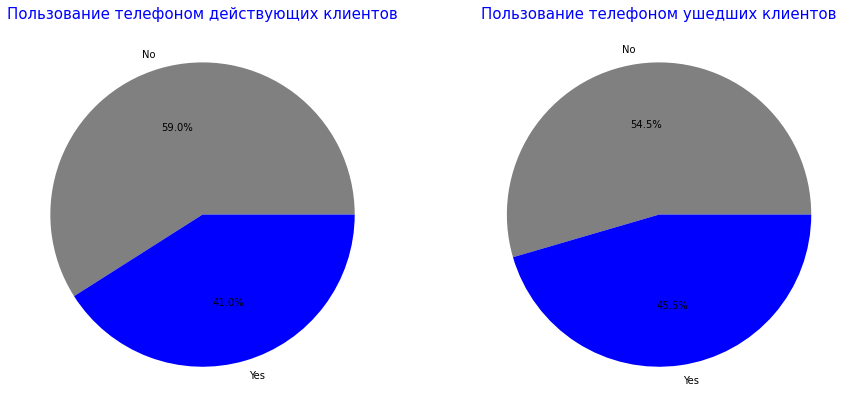

In [40]:
pie_plot(df_full, 'MultipleLines', 'Пользование телефоном')

#####  Пользование интернетом InternetService

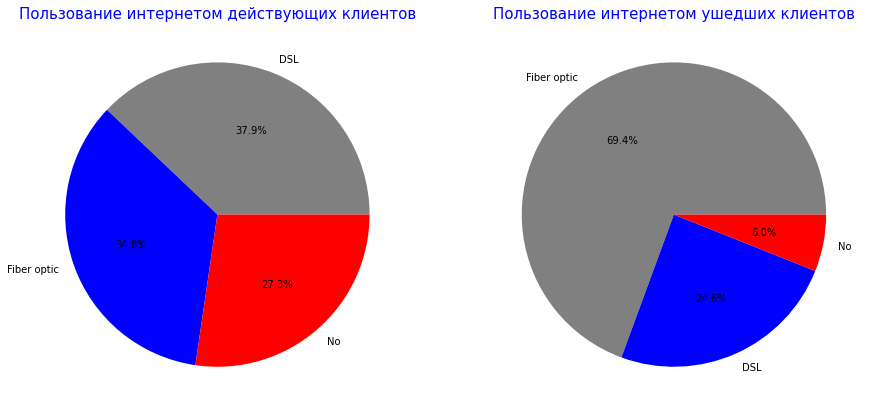

In [43]:
pie_plot(df_full, 'InternetService', 'Пользование интернетом')